# Data Retrieval

In [1]:
import pandas as pd
import csv
import re
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.ensemble import RandomForestRegressor

In [2]:
# File path for cities: San Francisco(sf), Okaland(ok), and Santa Clara(sc)

file_url = '/Users/xzhou/github/project_archives/files_airbnb/{}/calendar.csv'

sf_file = file_url.format('sf_airbnb')
ok_file = file_url.format('ok_airbnb')
sc_file = file_url.format('sc_airbnb')

In [3]:
# Loaded price by date information for each city

pricing_sf = pd.read_csv(sf_file, parse_dates=['date'])
pricing_ok = pd.read_csv(ok_file, parse_dates=['date'])
pricing_sc = pd.read_csv(sc_file, parse_dates=['date'])

print(pricing_sf.shape, pricing_ok.shape, pricing_sc.shape)

(2420680, 4) (1057770, 4) (2068820, 4)


In [4]:
# Concatenated all files into one
# Created keys for each file for future references

frames = [pricing_sf, pricing_ok, pricing_sc]
keys = ['pricing_sf', 'pricing_ok', 'pricing_sc']

df_pricing = pd.concat(frames, keys=keys)

df_pricing.head(10)

listing_id       date available price
pricing_sf 0         958 2019-08-05         f   NaN
           1         958 2019-08-04         f   NaN
           2         958 2019-08-03         f   NaN
           3         958 2019-08-02         f   NaN
           4         958 2019-08-01         f   NaN
           5         958 2019-07-31         f   NaN
           6         958 2019-07-30         f   NaN
           7         958 2019-07-29         f   NaN
           8         958 2019-07-28         f   NaN
           9         958 2019-07-27         f   NaN

# Data Exploration

## Smaller Set of Data

In [5]:
# Filter to houses that are available and have listing prices

df_pricing_smaller = df_pricing[df_pricing['available']=='t']
df_pricing_smaller = df_pricing_smaller.copy()

print('Dimension for df_pricing_smaller: ', df_pricing_smaller.shape)
print ('\nNumber of Unique ids: ', df_pricing_smaller.listing_id.nunique())

Dimension for df_pricing_smaller:  (2588352, 4)

Number of Unique ids:  13452


In [6]:
df_pricing_smaller.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

## Data Format

In [7]:
def apply2df(df, column_names, function):
    """
    This enables various functions to be applied to multiple columns of dataframe.
    Input: dataframe, columns to apply function to (list), function
    Return: updated dataframe
    """
    for column in column_names:
        df[column] = df[column].apply(lambda x: function(x))
    return df

### Currency

In [8]:
# Noted currencies are formated as strings and need to be converted to float

def currency2float(string):
    """
    Convert currency to float
    """
    float_ = float(str(string).strip('$').replace(',',''))
    return float_

In [9]:
# Converted price to float format

curriencies = ['price']

df_pricing_smaller = apply2df(df_pricing_smaller, curriencies, currency2float)

## Outliers

In [10]:
percentiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]

df_pricing_smaller.price.describe(percentiles=percentiles)

count    2.588352e+06
mean     2.056189e+02
std      7.335415e+02
min      1.000000e+01
5%       4.000000e+01
10%      5.000000e+01
25%      7.800000e+01
50%      1.290000e+02
75%      2.090000e+02
90%      3.500000e+02
95%      5.000000e+02
max      1.024520e+05
Name: price, dtype: float64

In [11]:
# Removed outliers based on 'price'. Use 5% and 95% percentiles as cutoff

five_percentile = np.percentile(df_pricing_smaller.price, 5)
ninety_five_percentile = np.percentile(df_pricing_smaller.price, 95)

df_pricing_smaller = df_pricing_smaller[(
                        df_pricing_smaller.price>=five_percentile)
                        & (df_pricing_smaller.price<=ninety_five_percentile)]

In [12]:
print ('df_pricing_smaller dimensions: ', df_pricing_smaller.shape)

df_pricing_smaller dimensions:  (2346265, 4)


## Null Values

In [13]:
df_pricing_smaller.isnull().sum()

listing_id    0
date          0
available     0
price         0
dtype: int64

In [14]:
df_pricing_smaller.shape

(2346265, 4)

In [15]:
columns2display = ['date', 'price']

df_pricing_smaller[columns2display].describe(include='all')

,date,price
count,2346265,2.346265e+06
unique,375,NaN
top,2018-11-03 00:00:00,NaN
freq,8671,NaN
first,2018-08-06 00:00:00,NaN
last,2019-08-15 00:00:00,NaN
mean,NaN,1.537473e+02
std,NaN,9.694863e+01
min,NaN,4.000000e+01
25%,NaN,8.000000e+01


## Seasonality Data

### Added Month and Day-of-Week(DOW) Features

In [16]:
# Added 'month' column to extract month of date
# Added 'day_of_week' column to extact day of week. 
# Default format: Monday=0, Sunday=6

df_pricing_smaller['month'] = df_pricing_smaller['date'].dt.month
df_pricing_smaller['day_of_week'] = df_pricing_smaller['date'].dt.weekday


print('df_pricing_smaller dimensions', df_pricing_smaller.shape)
display(df_pricing_smaller.head())

df_pricing_smaller dimensions (2346265, 6)


listing_id       date available  price  month  day_of_week
pricing_sf 63         958 2019-05-02         t  181.0      5            3
           64         958 2019-05-01         t  181.0      5            2
           65         958 2019-04-30         t  181.0      4            1
           66         958 2019-04-29         t  181.0      4            0
           67         958 2019-04-28         t  181.0      4            6

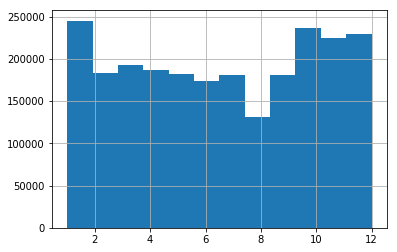

In [17]:
# Checked the price distribution by month

df_pricing_smaller.month.hist(bins=12)

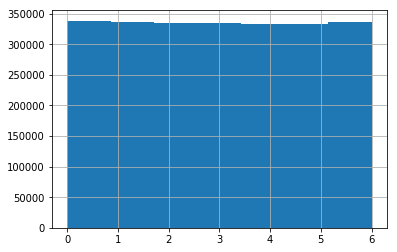

In [18]:
# Checked the price distribution by day of week

df_pricing_smaller.day_of_week.hist(bins=7)

### Pricing By Month by DOW

In [19]:
# Group by month by day of week, and calculate an average pricing

df_pricing_by_mon_dow = df_pricing_smaller  \
                            .groupby(['listing_id', 'month', 'day_of_week'])  \
                            .price.mean()  \
                            .reset_index()
df_pricing_by_mon_dow.head(100)

,listing_id,month,day_of_week,price
0,958,1,0,180.0
1,958,1,1,179.5
2,958,1,2,179.5
3,958,1,3,179.0
4,958,1,4,183.0
5,958,1,5,185.0
6,958,1,6,180.0
7,958,2,0,179.0
8,958,2,1,179.0
9,958,2,2,179.0


In [21]:
# Check for null values if any

df_pricing_by_mon_dow.isnull().sum()

listing_id     0
month          0
day_of_week    0
price          0
dtype: int64

In [22]:
# Rename the average price column to avoid confusion

df_pricing_by_mon_dow.rename(columns={'price':'price_by_month_dow'}, inplace=True)

In [23]:
df_pricing_by_mon_dow.shape

(625086, 4)

In [24]:
df_pricing_by_mon_dow.head()

,listing_id,month,day_of_week,price_by_month_dow
0,958,1,0,180.0
1,958,1,1,179.5
2,958,1,2,179.5
3,958,1,3,179.0
4,958,1,4,183.0


### Convert Month, DOW Info to Dummy Variables

In [27]:
def get_month(number):
    """
    Given a number, return the name of month.
    
    """
    month_lookup = {1:'Jan.', 2:'Feb.', 3:'Mar.', 4:'Apr.', 5:'May.', 6:'Jun.',
                    7:'Jul.', 8:'Aug.', 9:'Sep.', 10:'Oct.', 11:'Nov.', 12:'Dec.'}
    
    return month_lookup[number]

In [28]:
def get_dow(number):
    """
    Given a number, return the day of week (dow)
    
    """
    weekday_lookup = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
                      4:'Friday', 5:'Saturday', 6:'Sunday'}
    
    return weekday_lookup[number]

In [31]:
# Added names for month, and day of week(dow) informaiton

df_pricing_by_mon_dow = apply2df(df_pricing_by_mon_dow, ['month'], get_month )
df_pricing_by_mon_dow = apply2df(df_pricing_by_mon_dow, ['day_of_week'], get_dow )

In [35]:
# Converted month, and dow information to dummy variables

df_pricing_final = pd.get_dummies(df_pricing_by_mon_dow, 
                                  prefix='',
                                  prefix_sep='',
                                  columns=['month', 'day_of_week'])

print ('df_pricing_final dimensions: ', df_pricing_final.shape)
df_pricing_final.head()

df_pricing_final dimensions:  (625086, 21)


,listing_id,price_by_month_dow,Apr.,Aug.,Dec.,Feb.,Jan.,Jul.,Jun.,Mar.,...,Nov.,Oct.,Sep.,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,958,180.0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,958,179.5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,958,179.5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,958,179.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,958,183.0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [36]:
df_pricing_final.columns

Index(['listing_id', 'price_by_month_dow', 'Apr.', 'Aug.', 'Dec.', 'Feb.',
       'Jan.', 'Jul.', 'Jun.', 'Mar.', 'May.', 'Nov.', 'Oct.', 'Sep.',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

## Combined Seasonality Data with Previously Identified Features

In [39]:
# Loaded listings with identified important features

pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'

listings = pkl_file.format('df_listings_selected_features')

df_listings_features = pd.read_pickle(listings)

print ('df_listings_features dimensions: ', df_listings_features.shape)
df_listings_features.head()

df_listings_features dimensions:  (9062, 108)


,id,bedrooms,cleaning_fee,room_type_Entire home/apt,city_San Francisco,accommodates,city_Oakland,reviews_per_month,bathrooms,host_listings_count,...,amenities_Pets live on this property,is_location_exact_f,room_type_Shared room,amenities_Coffee maker,neighbourhood_cleansed_Potrero Hill,amenities_Heating,property_type_Townhouse,amenities_Microwave,ref_district,ref_jurisdiction
0,958,1.0,100.0,1,1,3,0,1.38,1.0,1,...,1,0,0,0,0,1,0,0,San Francisco,SAN FRANCISCO
1,5858,2.0,100.0,1,1,5,0,0.99,1.0,2,...,0,0,0,0,0,1,0,0,San Francisco,SAN FRANCISCO
2,7918,1.0,50.0,0,1,2,0,0.16,4.0,10,...,0,0,0,0,0,1,0,0,San Francisco,SAN FRANCISCO
3,8142,1.0,50.0,0,1,2,0,0.15,4.0,10,...,0,0,0,0,0,1,0,0,San Francisco,SAN FRANCISCO
4,8567,2.0,125.0,1,1,6,0,0.27,1.0,1,...,0,0,0,1,0,1,0,1,San Francisco,SAN FRANCISCO


In [40]:
df_listings_features.columns

Index(['id', 'bedrooms', 'cleaning_fee', 'room_type_Entire home/apt',
       'city_San Francisco', 'accommodates', 'city_Oakland',
       'reviews_per_month', 'bathrooms', 'host_listings_count',
       ...
       'amenities_Pets live on this property', 'is_location_exact_f',
       'room_type_Shared room', 'amenities_Coffee maker',
       'neighbourhood_cleansed_Potrero Hill', 'amenities_Heating',
       'property_type_Townhouse', 'amenities_Microwave', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=108)

In [41]:
# Combined listing data with seaonality information we just created

df_final = pd.merge(left=df_pricing_final, 
                    right=df_listings_features,
                    how='inner',
                    left_on='listing_id',
                    right_on='id')

In [43]:
df_final.columns

Index(['listing_id', 'price_by_month_dow', 'Apr.', 'Aug.', 'Dec.', 'Feb.',
       'Jan.', 'Jul.', 'Jun.', 'Mar.',
       ...
       'amenities_Pets live on this property', 'is_location_exact_f',
       'room_type_Shared room', 'amenities_Coffee maker',
       'neighbourhood_cleansed_Potrero Hill', 'amenities_Heating',
       'property_type_Townhouse', 'amenities_Microwave', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=129)

In [44]:
# Dropped duplicate columns

duplicate_columns = ['id']
df_final.drop(duplicate_columns, axis=1, inplace=True)

df_final.shape

### Features with High Correlation

In [45]:
# Create correlation matrix
# Select upper triangle of correlation matrix

corr_matrix = df_final.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

In [46]:
# Find index of feature columns with correlation greater than 0.90

thresold = 0.90
to_drop = [column for column in upper.columns if any(upper[column] >= thresold)]

to_drop

[]

In [47]:
# Drop features that have high correlation

df_final.drop(to_drop, axis=1, inplace=True)

In [48]:
df_final.shape

(407498, 128)

In [49]:
# Store the data prior to modeling
# When there're changes, mark file_updated as true. Changes'll be written to local files
# Otherwise, mark file_updated as false. Data will be loaded from existing files

file_updated = True
pkl_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.pkl'
listings_seasonality = pkl_file.format('listings_seasonality')


if file_updated:
    with open(listings_seasonality, 'wb') as file:
        pd.to_pickle(df_final, file)
else:
    try: 
        with open(listings_seasonality, 'rb') as file:
            df_final = pd.read_pickle(file)
    except:
        with open(listings_seasonality, 'wb') as file:
            pd.to_pickle(df_final, file)

# Modeling

In [50]:
df_final.columns

Index(['listing_id', 'price_by_month_dow', 'Apr.', 'Aug.', 'Dec.', 'Feb.',
       'Jan.', 'Jul.', 'Jun.', 'Mar.',
       ...
       'amenities_Pets live on this property', 'is_location_exact_f',
       'room_type_Shared room', 'amenities_Coffee maker',
       'neighbourhood_cleansed_Potrero Hill', 'amenities_Heating',
       'property_type_Townhouse', 'amenities_Microwave', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=128)

In [51]:
df_final.select_dtypes(include =['object']).columns

Index(['ref_district', 'ref_jurisdiction'], dtype='object')

In [53]:
# Multiple modelings will be performed for price prediction
# Data include 'listing_id', which will be used for stratified sampling

X = df_final.drop(['price_by_month_dow', 'ref_district', 'ref_jurisdiction'], axis=1)
y = df_final.loc[:, ['listing_id', 'price_by_month_dow']]

## Model Preprocessing

### Train and Test Sets Splits

In [54]:
# Stratified sampling to prevent information leakage
# Identified all available listing_ids and split by listing_ids

grp_by_listing_ids = df_final.groupby('listing_id').first().reset_index().listing_id
listing_ids = list(grp_by_listing_ids)

In [64]:
num_of_grps = len(grp_by_listing_ids)
training_ids = np.random.choice(listing_ids, int(num_of_grps*0.7),
                                replace=False)

print(len(training_ids))
training_ids

5814


array([24181120, 26918300, 23560384, ..., 20211607, 22866082,   676228])

In [65]:
testing_ids = set(grp_by_listing_ids) - set (training_ids)

len(testing_ids)

2493

In [66]:
# Stratified sampling: splited train and test sets. 
# Dropped 'listing_id' column

X_train = X[X['listing_id'].isin(training_ids)].drop('listing_id', axis=1)
X_test = X[X['listing_id'].isin(testing_ids)].drop('listing_id', axis=1)

y_train = y[y['listing_id'].isin(training_ids)].drop('listing_id', axis=1).values.ravel()
y_test = y[y['listing_id'].isin(testing_ids)].drop('listing_id', axis=1).values.ravel()

print(len(X_train), len(X_test), len(y_train), len(y_test))

285018 122480 285018 122480


### Feature Normalization

In [67]:
ss = StandardScaler()
X_train_trans = ss.fit_transform(X_train)
X_test_trans = ss.transform (X_test)

## Linear Regression

In [68]:
# Model-LR

model=sm.OLS(y_train, sm.add_constant(X_train_trans))
fit=model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     4707.
Date:                Sun, 17 Feb 2019   Prob (F-statistic):               0.00
Time:                        19:34:22   Log-Likelihood:            -1.5307e+06
No. Observations:              285018   AIC:                         3.062e+06
Df Residuals:                  284894   BIC:                         3.063e+06
Df Model:                         123                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        147.0815      0.098   1506.873      0.000     146.890     147.273
x1          -7.75e+10   2.67e+11     -0.291      0.771      -6e+11    4.45e+11
x2          -8.91e+10   3.06e+11     -0.291      0.771    -6.9e+11    5.12e+11
x3         -8.801e+10   3.03e+11     -0.291      0.771   -6.81e+11    5.05e+11
x4         -8.424e+10    2.9e+11     -0.291      0.771   -6.52e+11    4.84e+11
x5         -8.829e+10   3.04e+11     -0.291      0.771   -6.83e+11    5.07e+11
x6         -7.464e+10   2.57e+11     -0.291      0.771   -5.78e+11    4.28e+11
x7         -7.448e+10   2.56e+11     -0.291      0.771   -5.77e+11    4.28e+11
x8         -7.748e+10   2.66e+11     -0.291      0.771      -6e+11    4.45e+11
x9         -7.649e+10   2.63e+11     -0.291      0.771   -5.92e+11    4.39e+11
x10        -9.223e+10   3.17e+11     -0.291      0.771   -7.14e+11    5.29e+11
x11        -9.185e+10   3.16e+11     -0.291      0.771   -7.11e+11    5.27e+11
x12        -8.728e+10      3e+11     -0.291      0.771   -6.76e+11    5.01e+11
x13         -1.57e+12   1.83e+12     -0.859      0.390   -5.15e+12    2.01e+12
x14        -1.561e+12   1.82e+12     -0.859      0.390   -5.12e+12       2e+12
x15        -1.559e+12   1.82e+12     -0.859      0.390   -5.12e+12       2e+12
x16        -1.563e+12   1.82e+12     -0.859      0.390   -5.13e+12       2e+12
x17        -1.565e+12   1.82e+12     -0.859      0.390   -5.14e+12    2.01e+12
x18        -1.549e+12    1.8e+12     -0.859      0.390   -5.09e+12    1.99e+12
x19        -1.551e+12   1.81e+12     -0.859      0.390   -5.09e+12    1.99e+12
x20           23.1303      0.173    133.781      0.000      22.791      23.469
x21            7.6427      0.138     55.363      0.000       7.372       7.913
x22           22.7497      0.158    144.043      0.000      22.440      23.059
x23           16.8160      0.638     26.374      0.000      15.566      18.066
x24           23.2155      0.219    105.900      0.000      22.786      23.645
x25           -0.2454      0.474     -0.518      0.604      -1.174       0.683
x26           -3.9935      0.176    -22.710      0.000      -4.338      -3.649
x27            1.9299      0.116     16.681      0.000       1.703       2.157
x28            4.8355      0.149     32.381      0.000       4.543       5.128
x29           -2.6082      0.181    -14.444      0.000      -2.962      -2.254
x30            1.2659      0.129      9.776      0.000       1.012       1.520
x31            4.2227      0.215     19.606      0.000       3.801       4.645
x32            3.6095      0.132     27.311      0.000       3.351       3.869
x33            6.3596      0.125     50.733      0.000       6.114       6.605
x34          -11.0105      0.153    -72.082      0.000     -11.310     -10.711
x35           -1.5356      0.169     -9.076      0.000      -1.867      -1.204
x3

## Random Forest

In [69]:
# Model-Random Forest

rf = RandomForestRegressor(n_estimators=100, 
                           criterion='mse', 
                           random_state=42, 
                           verbose=1,
                           n_jobs=-1)
rf.fit(X_train_trans, y_train.ravel())

y_train_pred = rf.predict(X_train_trans)
y_test_pred = rf.predict(X_test_trans)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s


MSE train: 6.267, test: 3792.467
R^2 train: 0.999, test: 0.573


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.5s finished


In [70]:
df_final.listing_id.nunique()

8307

In [71]:
# Double check on price range. The range is as expected

y.describe(include='all')

,listing_id,price_by_month_dow
count,4.074980e+05,407498.000000
mean,1.244814e+07,148.773985
std,8.175362e+06,91.755807
min,9.580000e+02,40.000000
25%,4.718531e+06,80.000000
50%,1.276166e+07,122.000000
75%,1.983121e+07,195.000000
max,2.770097e+07,500.000000


In [72]:
# Map feature importance with labels

feature_labels = X.columns
feature_tuples = zip (feature_labels, rf.feature_importances_)
feature_lists = [list(feature_tuple) for feature_tuple in feature_tuples]

In [73]:
# Order features based on importance

feature_lists.sort(key=lambda x: abs(x[1]), reverse=True)
feature_lists

[['Wednesday', 0.37971569408383465],
 ['cleaning_fee', 0.08110699081912717],
 ['bedrooms', 0.04511645307412085],
 ['city_Oakland', 0.03990042697837719],
 ['room_type_Entire home/apt', 0.034789240607198374],
 ['city_San Francisco', 0.03437000621493019],
 ['reviews_per_month', 0.034328754064099375],
 ['bathrooms', 0.02111020820475603],
 ['host_listings_count', 0.016822318218640248],
 ['accommodates', 0.016749182903555992],
 ['beds', 0.015683046885371067],
 ['review_scores_location', 0.014083632935195933],
 ['number_of_reviews', 0.01283095532215107],
 ['guests_included', 0.012348330226083577],
 ['host_yrs', 0.012253101298910224],
 ['review_scores_rating', 0.012136089917745339],
 ['neighbourhood_cleansed_Chinatown', 0.009635217719861235],
 ['amenities_Shampoo', 0.009082293547920367],
 ['amenities_Carbon monoxide detector', 0.00792961777173564],
 ['calculated_host_listings_count', 0.0069972550574293165],
 ['yrs_since_1st_review', 0.005495577450376576],
 ['amenities_Indoor fireplace', 0.0046

In [74]:
features = [list_[0] for list_ in feature_lists]
features

['Wednesday',
 'cleaning_fee',
 'bedrooms',
 'city_Oakland',
 'room_type_Entire home/apt',
 'city_San Francisco',
 'reviews_per_month',
 'bathrooms',
 'host_listings_count',
 'accommodates',
 'beds',
 'review_scores_location',
 'number_of_reviews',
 'guests_included',
 'host_yrs',
 'review_scores_rating',
 'neighbourhood_cleansed_Chinatown',
 'amenities_Shampoo',
 'amenities_Carbon monoxide detector',
 'calculated_host_listings_count',
 'yrs_since_1st_review',
 'amenities_Indoor fireplace',
 'review_scores_communication',
 'amenities_Self checkin',
 'neighbourhood_cleansed_Haight Ashbury',
 'neighbourhood_cleansed_San Jose',
 'host_response_time_within a few hours',
 'Sep.',
 'Monday',
 'amenities_Free parking on premises',
 'amenities_Private entrance',
 'amenities_Pets live on this property',
 'host_identity_verified_f',
 'Oct.',
 'amenities_Cable TV',
 'Apr.',
 'amenities_Lock on bedroom door',
 'property_type_Apartment',
 'property_type_House',
 'amenities_First aid kit',
 'ameniti

In [75]:
# 'ref_dist', 'ref_juri', 'ref_jurisdiction', 'price_by_month_week'


columns =['listing_id']
columns.extend(features)
columns.extend(['ref_district', 'ref_jurisdiction', 'price_by_month_dow'])

In [76]:
df_data = df_final[columns]
df_data.head()

,listing_id,Wednesday,cleaning_fee,bedrooms,city_Oakland,room_type_Entire home/apt,city_San Francisco,reviews_per_month,bathrooms,host_listings_count,...,Saturday,neighbourhood_cleansed_Downtown/Civic Center,Sunday,Thursday,Tuesday,host_response_rate,Friday,ref_district,ref_jurisdiction,price_by_month_dow
0,958,0,100.0,1.0,0,1,1,1.38,1.0,1,...,0,0,0,0,0,0.92,0,San Francisco,SAN FRANCISCO,180.0
1,958,0,100.0,1.0,0,1,1,1.38,1.0,1,...,0,0,0,0,1,0.92,0,San Francisco,SAN FRANCISCO,179.5
2,958,1,100.0,1.0,0,1,1,1.38,1.0,1,...,0,0,0,0,0,0.92,0,San Francisco,SAN FRANCISCO,179.5
3,958,0,100.0,1.0,0,1,1,1.38,1.0,1,...,0,0,0,1,0,0.92,0,San Francisco,SAN FRANCISCO,179.0
4,958,0,100.0,1.0,0,1,1,1.38,1.0,1,...,0,0,0,0,0,0.92,1,San Francisco,SAN FRANCISCO,183.0


In [77]:
df_data.shape

(407498, 128)

In [78]:
df_data.rename(columns={'price_by_month_dow':'price'}, inplace=True)

In [79]:
df_data.isnull().sum()

listing_id                                            0
Wednesday                                             0
cleaning_fee                                          0
bedrooms                                              0
city_Oakland                                          0
room_type_Entire home/apt                             0
city_San Francisco                                    0
reviews_per_month                                     0
bathrooms                                             0
host_listings_count                                   0
accommodates                                          0
beds                                                  0
review_scores_location                                0
number_of_reviews                                     0
guests_included                                       0
host_yrs                                              0
review_scores_rating                                  0
neighbourhood_cleansed_Chinatown                

In [ ]:
temp_df = df_data[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].copy()

days = temp_df.apply(lambda x: x.idxmax(), axis=1)
days

In [ ]:
csv_file = '/Users/xzhou/github/project_archives/files_airbnb/{}.csv'

csv_path = csv_file.format('airbnb_data')

df_data.to_csv(csv_path)

In [81]:
# This is to create visual to show seasonality

df_visual = pd.merge(left=df_pricing_by_mon_dow, 
                    right=df_listings_features,
                    how='inner',
                    left_on='listing_id',
                    right_on='id')

In [ ]:
# df_visual = df_final.copy()

In [ ]:
df_visual.shape

In [88]:
df_visual.columns

Index(['listing_id', 'month', 'day_of_week', 'price_by_month_dow', 'id',
       'bedrooms', 'cleaning_fee', 'room_type_Entire home/apt',
       'city_San Francisco', 'accommodates',
       ...
       'amenities_Pets live on this property', 'is_location_exact_f',
       'room_type_Shared room', 'amenities_Coffee maker',
       'neighbourhood_cleansed_Potrero Hill', 'amenities_Heating',
       'property_type_Townhouse', 'amenities_Microwave', 'ref_district',
       'ref_jurisdiction'],
      dtype='object', length=112)

In [82]:
df_visual_ent_apart = df_visual[df_visual['room_type_Entire home/apt']==1 ]
df_visual_sing_room = df_visual[df_visual['room_type_Entire home/apt']!=1 ]

print(df_visual_ent_apart.shape, df_visual_sing_room.shape )

(216975, 112) (190523, 112)


In [83]:
df_visual_ent_apart.ref_district.describe

<bound method NDFrame.describe of 0         San Francisco
1         San Francisco
2         San Francisco
3         San Francisco
4         San Francisco
5         San Francisco
6         San Francisco
7         San Francisco
8         San Francisco
9         San Francisco
10        San Francisco
11        San Francisco
12        San Francisco
13        San Francisco
14        San Francisco
15        San Francisco
16        San Francisco
17        San Francisco
18        San Francisco
19        San Francisco
20        San Francisco
21        San Francisco
22        San Francisco
23        San Francisco
24        San Francisco
25        San Francisco
26        San Francisco
27        San Francisco
28        San Francisco
29        San Francisco
              ...      
407467      Santa Clara
407468      Santa Clara
407469      Santa Clara
407470      Santa Clara
407471      Santa Clara
407472      Santa Clara
407473      Santa Clara
407474      Santa Clara
407475      Santa Clara
407476

In [ ]:
# df_visual_entire_apartment_sf = df_visual_entire_apartment[
#                            df_visual_entire_apartment['ref_district']=='San Francisco']
# df_visual_entire_apartment_scz = df_visual_entire_apartment[df_visual_entire_apartment['ref_district']=='Santa Clara']

# print(df_visual_entire_apartment_sf.shape, df_visual_entire_apartment_scz.shape )

In [ ]:
# df_visual_entire_apartment_sf.listing_id.nunique()

In [ ]:
# df_visual_entire_apartment_scz.listing_id.nunique()

In [91]:
# Weekly pattern for entire apartment

df_ent_apart_by_dow = df_visual_ent_apart  \
                          .groupby(['ref_district', 'day_of_week'])  \
                          .price_by_month_dow.mean()
df_ent_apart_by_dow

ref_district   day_of_week
Oakland        Friday         151.028933
               Monday         146.200905
               Saturday       151.393272
               Sunday         147.249513
               Thursday       146.529586
               Tuesday        145.668259
               Wednesday      146.044186
San Francisco  Friday         211.177964
               Monday         204.813449
               Saturday       211.109980
               Sunday         205.917327
               Thursday       205.669198
               Tuesday        205.042800
               Wednesday      204.863768
Santa Clara    Friday         204.755467
               Monday         203.117403
               Saturday       204.360394
               Sunday         202.663630
               Thursday       203.922394
               Tuesday        203.767863
               Wednesday      204.424058
Name: price_by_month_dow, dtype: float64

In [92]:
# Weekly pattern for single room

df_sing_room_by_dow = df_visual_sing_room  \
                          .groupby(['ref_district', 'day_of_week'])  \
                          .price_by_month_dow.mean()
df_sing_room_by_dow

ref_district   day_of_week
Oakland        Friday          75.503706
               Monday          73.765381
               Saturday        75.507196
               Sunday          73.547569
               Thursday        73.802102
               Tuesday         73.691687
               Wednesday       73.764326
San Francisco  Friday         124.724201
               Monday         119.657800
               Saturday       124.368007
               Sunday         120.494809
               Thursday       120.571680
               Tuesday        119.798881
               Wednesday      120.029255
Santa Clara    Friday          79.822268
               Monday          78.567982
               Saturday        79.825026
               Sunday          78.528311
               Thursday        78.618272
               Tuesday         78.595941
               Wednesday       78.560329
Name: price_by_month_dow, dtype: float64

In [93]:
# Montly Pattern for entire apartment

df_visual_ent_apart.groupby(['ref_district', 'month']).price_by_month_dow.mean()

ref_district   month
Oakland        Apr.     152.970769
               Aug.     148.046702
               Dec.     147.074091
               Feb.     144.675173
               Jan.     145.036679
               Jul.     153.580032
               Jun.     154.348160
               Mar.     152.671308
               May.     153.089479
               Nov.     140.798115
               Oct.     144.104286
               Sep.     145.338658
San Francisco  Apr.     204.427314
               Aug.     214.192272
               Dec.     203.903778
               Feb.     203.842070
               Jan.     206.127438
               Jul.     206.556149
               Jun.     206.050272
               Mar.     205.269812
               May.     203.235148
               Nov.     201.374033
               Oct.     210.140963
               Sep.     218.031384
Santa Clara    Apr.     211.881164
               Aug.     204.718970
               Dec.     198.585578
               Feb.     202.676910

In [94]:
# Montly Pattern for single room

df_visual_sing_room.groupby(['ref_district', 'month']).price_by_month_dow.mean()

ref_district   month
Oakland        Apr.      74.916126
               Aug.      75.835302
               Dec.      73.145327
               Feb.      74.318976
               Jan.      73.073431
               Jul.      74.663438
               Jun.      74.567812
               Mar.      75.157040
               May.      74.674819
               Nov.      72.251279
               Oct.      73.197049
               Sep.      76.137786
San Francisco  Apr.     118.745724
               Aug.     127.420532
               Dec.     118.117639
               Feb.     117.829924
               Jan.     119.175408
               Jul.     118.703700
               Jun.     118.634880
               Mar.     118.176623
               May.     118.150702
               Nov.     118.061622
               Oct.     124.222997
               Sep.     133.589617
Santa Clara    Apr.      80.019167
               Aug.      78.932060
               Dec.      76.965656
               Feb.      79.407598